In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import re
import jieba
import time
import jieba.analyse
import wordcloud
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

- 爬取页面
    - 抓取公司名词/规模/岗位描述/任职要求
    - 数据清洗 存入csv文件
- 对任职要求做分词
  每一个job有个requirement。 那最终我们有的就是list(requierment). 对其做分词. 
- 词云. top n
- seaborn 柱状图 概率图展示
  
  
从上文可知，我们已经能获取到节点对象，但有时候需要获取其父节点或者子节点的内容，我们要怎么做了？这就需要对parse tree进行遍历

（1）获取子节点
利用.children属性，该属性会返回当前节点所以的子节点。但是它返回的类型不是列表，而是迭代器

（2）获取所有子孙节点
使用.descendants属性，它会返回所有子孙节点的迭代器

（3）获取父节点
通过.parent属性可以获得所有子孙节点的迭代器

（4）获取所有父节点
.parents属性，也是返回所有子孙节点的迭代器

（5）获取兄弟节点
兄弟节点可以理解为和本节点处在统一级的节点，.next_sibling属性获取了该节点的下一个兄弟节点，.previous_sibling则与之相反，如果节点不存在，则返回 None

注意：实际 HTML 中的 tag 的.next_sibling和 .previous_sibling属性通常是字符串或空白，因为空白或者换行也可以被视作一个节点，所以得到的结果可能是空白或者换行

（5）获取所有兄弟节点
通过.next_siblings和.previous_siblings属性可以对当前节点的兄弟节点迭代输出


判断是否是某种类型 if type(sec) is not bs4.element.NavigableString:
https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python  有用的string操作
https://stackoverflow.com/questions/31210985/python-3-cant-delete-a-space-in-a-string-using-replace replace white space中文的问题


### 爬页面
https://www.zhipin.com/job_detail/?query=nlp&scity=101190100&industry=&position=
    
https://www.zhipin.com/job_detail/a9d8aa2186a5ef6d1XV729i8E1I~.html?ka=search_list_1
https://www.zhipin.com/job_detail/5f59ea8017f7a96f1XB-2964GVo~.html?ka=search_list_2    


In [2]:
h="<html><a href=\"/gongsi/3c5a5ab5f136c40f1Xdz0t-0FA~~.html\" ka=\"search_list_company_1_custompage\" target=\"_blank\">的卢技术</a></html>"
test = BeautifulSoup(h,"html.parser")
print(test.string)
#for c in test.a.children:
    #print(c)

的卢技术


In [3]:
current_url = "https://www.zhipin.com/job_detail/?query=nlp&scity=101190100&industry=&position="
headers = {
           'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36'
           ,'Connection': 'keep-alive'
           }
r=requests.get(current_url,headers=headers)

In [4]:
"能够使用Django框架进行后端服务开发；".find("任职要求")
"                                    任职要求：".replace(" ","")
"                                    任职要求：".strip()

'任职要求：'

In [5]:
def parse_job_detail(url):
    r=requests.get(url,headers=headers)
    bs = BeautifulSoup(r.text,"html.parser")
    h3=bs.find("h3",text="职位描述")
    #print(h3.find_next_sibling("div"))
    div_tag = h3.find_next_sibling("div")
    #print(div_tag.text)
    requirements = []#任职要求
    responsbility = []#岗位职责
    require_flag = False
    responsbility_flag = False
    for c in div_tag.children:
        #print(c,type(c))
        if type(c) is bs4.element.NavigableString:
            str_no_space = c.string.replace(" ","")
            #print(str_no_space)
            
            if str_no_space.find("任职要求") != -1:   #这边不能用==判断  因为前面由于中文字符的问题 replace替换不掉：后面的blank
                responsbility_flag = False
                require_flag = True
                continue
                
            if str_no_space.find("岗位职责") != -1:   #这边不能用==判断  因为前面由于中文字符的问题 replace替换不掉：后面的blank
                require_flag = False
                responsbility_flag = True           
                continue
            
            if require_flag:
                requirements.append(str_no_space)
            if responsbility_flag:
                responsbility.append(str_no_space)
                        
    #print(requirements)  
    #print(responsbility)
    return (requirements,responsbility)

#parse_job_detail("https://www.zhipin.com/job_detail/84e81e27c933269e1Xxz3dq1E1I~.html?ka=search_list_1")

In [6]:
def  get_jobs_info(url):
    r=requests.get(url,headers=headers)
    bs = BeautifulSoup(r.text,"html.parser")
    jobs = []
    for job in bs.find_all("div",class_="job-primary"):
        #print("**************************************************************")
        one_job = []
        for child in job.descendants:   
            if child.name == 'div'and child['class'] == ['info-primary']:
                jobdetails = parse_job_detail("https://www.zhipin.com/%s" % (child.h3.a.get('href')))
                one_job.append(child.h3.div.text)  #title
                #print(one_job)
                one_job.append(child.h3.span.text) #salary  #15-20K取中位数
                #one_job.append(child.h3.a.get('href')) #link
                one_job.append(jobdetails[0]) #requirements
                one_job.append(jobdetails[1]) #responsbility
                index = 0
                for c in child.p:
                    if index == 0:
                        #print(c)   
                        one_job.append(c)  #地区
                    elif index == 2:
                        #print(c)   
                        one_job.append(c)  #经验
                    elif index == 4:
                        #print(c)   
                        one_job.append(c)  #学历
                    index += 1
            elif child.name == 'div' and child['class'] == ['info-company']:
                #print(child.a.string)
                index = 0
                for c in child.p:
                    if index == 0:
                        #print(c)    #行业
                        one_job.append(c)
                    elif index == 2:
                        #print(c)    #公司发展阶段 A/B/C/D轮/上市
                        one_job.append(c)
                    elif index == 4:
                        #print(c)    #规模
                        one_job.append(c)

                    index += 1
                    pass
        #print(one_job)  
        jobs.append(one_job)

    return jobs
    
jobs_info=get_jobs_info("https://www.zhipin.com/job_detail/?query=nlp&scity=101190100&industry=&position=")

In [7]:
len(jobs_info)
len(jobs_info[0])
l=[[1,2,3],[4,5,6],[7,8,9]]
df=pd.DataFrame(l)

In [8]:
df=pd.DataFrame(jobs_info)
df.columns=['职位名称','月薪','任职要求','岗位职责','地区','经验','学历','行业','发展阶段','规模']

In [9]:
df

,职位名称,月薪,任职要求,岗位职责,地区,经验,学历,行业,发展阶段,规模
0,NLP算法工程师,15k-30k,[],[],南京 江宁区 东山,1-3年,硕士,互联网,C轮,10000人以上
1,NLP算法工程师,15k-30k,"[1.对机器学习、自然语言处理有深刻的理解，熟悉NLP领域常用算法；, 2.熟练使用Tens...",[1.NLP领域：词法分析、句法分析、语法分析、信息挖掘、知识图谱、分词、词性标注、实体识别...,南京 江宁区,3-5年,本科,通信/网络设备,已上市,1000-9999人
2,NLP算法工程师,15k-30k,[],[],南京 雨花台区 铁心桥,3-5年,硕士,互联网,已上市,1000-9999人
3,NLP算法工程师,17k-28k,[1、熟悉CNN、RNN、LSTM、Word2Vec、CRF++、Bert等模型基本原理，了...,[1、负责内部事件回测投资系统、智能投研系统、智能客服对话、智能舆情等FinTech最新前沿...,南京,1-3年,硕士,互联网金融,已上市,1000-9999人
4,NLP工程师,10k-15k,[],"[1、参与公司核心平台及产品的设计、开发及优化工作；, 2、参与项目需求分析和NLP相关算法...",南京,1-3年,本科,数据服务,天使轮,0-20人
5,NLP算法工程师,20k-30k,"[1.熟悉NLP领域的理论基础，掌握统计模型、机器学习相关原理；, 2.具有NLP实战经验，...",[1.负责海量数据治理、文本分类、情感分析、话题分析、话题摘要、观点识别、语义理解等NLP智...,南京,3-5年,硕士,信息安全,不需要融资,1000-9999人
6,NLP算法实习生,4k-6k,[],[],南京 栖霞区 尧化,经验不限,本科,计算机软件,B轮,1000-9999人
7,NLP开发工程师,22k-30k,"[1、研究生及以上学历，5年以上工作经验，211、985优先；, 2、自然语言处理方向3年以...",[1.负责自然语言处理（NLP）相关的研发工作，包括文本分类与聚类、中文分词、实体识别、关键...,南京 雨花台区 铁心桥,3-5年,硕士,智能硬件,A轮,100-499人
8,服务器开发工程师（NLP方向）,20k-40k,"[1.计算机及相关专业本科以上学历；, 2.能够使用Django框架进行后端服务开发；, 3...","[1.参与NLP相关项目的方案设计、开发、测试等工作；, 2.开发NLP平台,工作内容包括语...",南京,5-10年,本科,互联网,已上市,10000人以上
9,NLP自然语言处理,10k-20k,[],[1、了解机器学习和自然语言处理的常用算法（文本分类、聚类、自动推荐、中文分词、序列化标注、...,南京 江宁区 百家湖,1-3年,硕士,计算机软件,A轮,100-499人


解决sns显示中文字体的问题  
from matplotlib.font_manager import FontProperties  
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)  
sns.set(font=myfont.get_name())

In [10]:
from matplotlib.font_manager import FontProperties  
myfont=FontProperties(fname=r'C:\Windows\Fonts\simhei.ttf',size=14)  
sns.set(font=myfont.get_name())

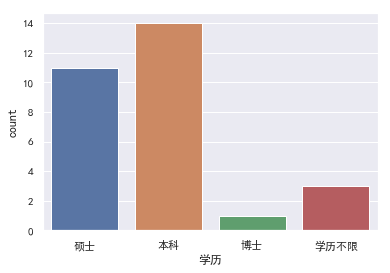

In [11]:
#可以看到学历要求硕士的占了有小一半了.实际上这个比例要更高.有的标着本科的在职位详情里其实要求硕士
sns.countplot(x="学历",data=df) 

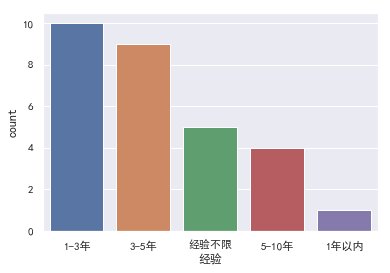

In [12]:
#3年左右最吃香.主要是现在很多要招于深度学习有关的. 深度学习的大火也没几年,市场上有特别丰富经验的人也不多.
sns.countplot(x="经验",data=df) 

互联网        9
计算机软件      8
信息安全       3
智能硬件       3
批发/零售      1
数据服务       1
通信/网络设备    1
移动互联网      1
计算机服务      1
互联网金融      1
Name: 行业, dtype: int64
本科      14
硕士      11
学历不限     3
博士       1
Name: 学历, dtype: int64
1-3年     10
3-5年      9
经验不限      5
5-10年     4
1年以内      1
Name: 经验, dtype: int64
学历    经验   
博士    3-5年     1
学历不限  1-3年     1
      经验不限     2
本科    1-3年     3
      1年以内     1
      3-5年     4
      5-10年    3
      经验不限     3
硕士    1-3年     6
      3-5年     4
      5-10年    1
dtype: int64


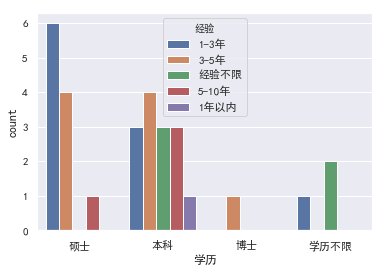

In [13]:
print(df["行业"].value_counts())
print(df["学历"].value_counts())
print(df["经验"].value_counts())
print(df.groupby(["学历","经验"]).size())
sns.countplot(x="学历", hue="经验", data=df) 

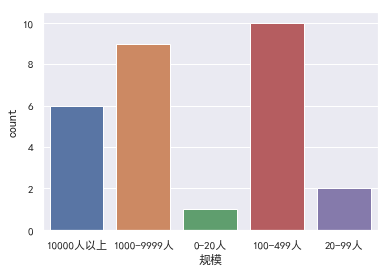

In [14]:
#说明大公司要的人多
sns.countplot(x="规模", data=df)  

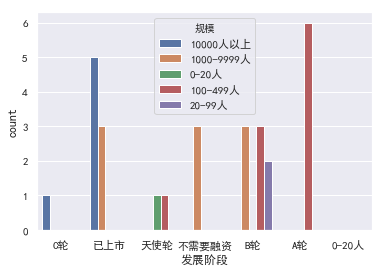

In [15]:
sns.countplot(x="发展阶段",hue="规模",data=df) 

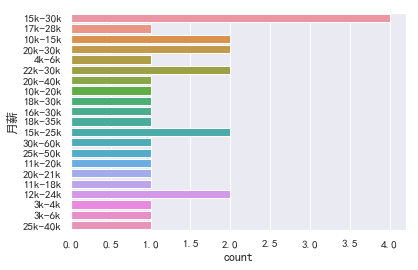

In [16]:
df["月薪"].value_counts()
sns.countplot(y="月薪", data=df)

In [17]:
#处理月薪数据
def f(s):
    #x="17k-18k"
    l = s.replace('k','').split('-')

    tmp=[int(e) for e in l]
    return sum(tmp)/len(tmp)

df["平均月薪"]=df["月薪"].apply(f)
#df.dtypes
#s="17k-18k"
#s=s.replace('k','')
#s.split('-')

In [18]:
df

,职位名称,月薪,任职要求,岗位职责,地区,经验,学历,行业,发展阶段,规模,平均月薪
0,NLP算法工程师,15k-30k,[],[],南京 江宁区 东山,1-3年,硕士,互联网,C轮,10000人以上,22.5
1,NLP算法工程师,15k-30k,"[1.对机器学习、自然语言处理有深刻的理解，熟悉NLP领域常用算法；, 2.熟练使用Tens...",[1.NLP领域：词法分析、句法分析、语法分析、信息挖掘、知识图谱、分词、词性标注、实体识别...,南京 江宁区,3-5年,本科,通信/网络设备,已上市,1000-9999人,22.5
2,NLP算法工程师,15k-30k,[],[],南京 雨花台区 铁心桥,3-5年,硕士,互联网,已上市,1000-9999人,22.5
3,NLP算法工程师,17k-28k,[1、熟悉CNN、RNN、LSTM、Word2Vec、CRF++、Bert等模型基本原理，了...,[1、负责内部事件回测投资系统、智能投研系统、智能客服对话、智能舆情等FinTech最新前沿...,南京,1-3年,硕士,互联网金融,已上市,1000-9999人,22.5
4,NLP工程师,10k-15k,[],"[1、参与公司核心平台及产品的设计、开发及优化工作；, 2、参与项目需求分析和NLP相关算法...",南京,1-3年,本科,数据服务,天使轮,0-20人,12.5
5,NLP算法工程师,20k-30k,"[1.熟悉NLP领域的理论基础，掌握统计模型、机器学习相关原理；, 2.具有NLP实战经验，...",[1.负责海量数据治理、文本分类、情感分析、话题分析、话题摘要、观点识别、语义理解等NLP智...,南京,3-5年,硕士,信息安全,不需要融资,1000-9999人,25.0
6,NLP算法实习生,4k-6k,[],[],南京 栖霞区 尧化,经验不限,本科,计算机软件,B轮,1000-9999人,5.0
7,NLP开发工程师,22k-30k,"[1、研究生及以上学历，5年以上工作经验，211、985优先；, 2、自然语言处理方向3年以...",[1.负责自然语言处理（NLP）相关的研发工作，包括文本分类与聚类、中文分词、实体识别、关键...,南京 雨花台区 铁心桥,3-5年,硕士,智能硬件,A轮,100-499人,26.0
8,服务器开发工程师（NLP方向）,20k-40k,"[1.计算机及相关专业本科以上学历；, 2.能够使用Django框架进行后端服务开发；, 3...","[1.参与NLP相关项目的方案设计、开发、测试等工作；, 2.开发NLP平台,工作内容包括语...",南京,5-10年,本科,互联网,已上市,10000人以上,30.0
9,NLP自然语言处理,10k-20k,[],[1、了解机器学习和自然语言处理的常用算法（文本分类、聚类、自动推荐、中文分词、序列化标注、...,南京 江宁区 百家湖,1-3年,硕士,计算机软件,A轮,100-499人,15.0


[Text(0,0.5,'公司数量'), Text(0.5,0,'平均月薪(单位k)')]

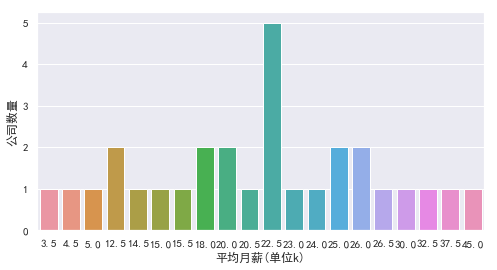

In [19]:
#sns.countplot(y="平均月薪",hue="规模" data=df)
#sns.set_context("paper", rc={"axes.labelsize":36})
plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high
ax=sns.countplot(x="平均月薪",data=df) 
ax.set(xlabel='平均月薪(单位k)', ylabel='公司数量')

In [20]:
len(df)

29

In [21]:
#招聘方说15-20k  一般意思就是15k.
def min_salary(s):
    #x="17k-18k"
    l = s.replace('k','').split('-')

    return int(l[0])

df["最低月薪"]=df["月薪"].apply(min_salary)

In [22]:
df

,职位名称,月薪,任职要求,岗位职责,地区,经验,学历,行业,发展阶段,规模,平均月薪,最低月薪
0,NLP算法工程师,15k-30k,[],[],南京 江宁区 东山,1-3年,硕士,互联网,C轮,10000人以上,22.5,15
1,NLP算法工程师,15k-30k,"[1.对机器学习、自然语言处理有深刻的理解，熟悉NLP领域常用算法；, 2.熟练使用Tens...",[1.NLP领域：词法分析、句法分析、语法分析、信息挖掘、知识图谱、分词、词性标注、实体识别...,南京 江宁区,3-5年,本科,通信/网络设备,已上市,1000-9999人,22.5,15
2,NLP算法工程师,15k-30k,[],[],南京 雨花台区 铁心桥,3-5年,硕士,互联网,已上市,1000-9999人,22.5,15
3,NLP算法工程师,17k-28k,[1、熟悉CNN、RNN、LSTM、Word2Vec、CRF++、Bert等模型基本原理，了...,[1、负责内部事件回测投资系统、智能投研系统、智能客服对话、智能舆情等FinTech最新前沿...,南京,1-3年,硕士,互联网金融,已上市,1000-9999人,22.5,17
4,NLP工程师,10k-15k,[],"[1、参与公司核心平台及产品的设计、开发及优化工作；, 2、参与项目需求分析和NLP相关算法...",南京,1-3年,本科,数据服务,天使轮,0-20人,12.5,10
5,NLP算法工程师,20k-30k,"[1.熟悉NLP领域的理论基础，掌握统计模型、机器学习相关原理；, 2.具有NLP实战经验，...",[1.负责海量数据治理、文本分类、情感分析、话题分析、话题摘要、观点识别、语义理解等NLP智...,南京,3-5年,硕士,信息安全,不需要融资,1000-9999人,25.0,20
6,NLP算法实习生,4k-6k,[],[],南京 栖霞区 尧化,经验不限,本科,计算机软件,B轮,1000-9999人,5.0,4
7,NLP开发工程师,22k-30k,"[1、研究生及以上学历，5年以上工作经验，211、985优先；, 2、自然语言处理方向3年以...",[1.负责自然语言处理（NLP）相关的研发工作，包括文本分类与聚类、中文分词、实体识别、关键...,南京 雨花台区 铁心桥,3-5年,硕士,智能硬件,A轮,100-499人,26.0,22
8,服务器开发工程师（NLP方向）,20k-40k,"[1.计算机及相关专业本科以上学历；, 2.能够使用Django框架进行后端服务开发；, 3...","[1.参与NLP相关项目的方案设计、开发、测试等工作；, 2.开发NLP平台,工作内容包括语...",南京,5-10年,本科,互联网,已上市,10000人以上,30.0,20
9,NLP自然语言处理,10k-20k,[],[1、了解机器学习和自然语言处理的常用算法（文本分类、聚类、自动推荐、中文分词、序列化标注、...,南京 江宁区 百家湖,1-3年,硕士,计算机软件,A轮,100-499人,15.0,10


[Text(0,0.5,'公司数量'), Text(0.5,0,'最低月薪(单位k)')]

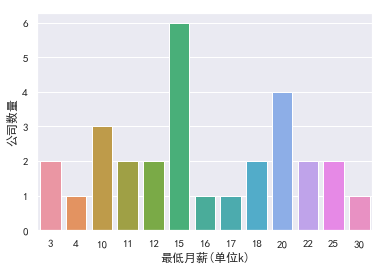

In [23]:
ax=sns.countplot(x="最低月薪",data=df) 
ax.set(xlabel='最低月薪(单位k)', ylabel='公司数量')

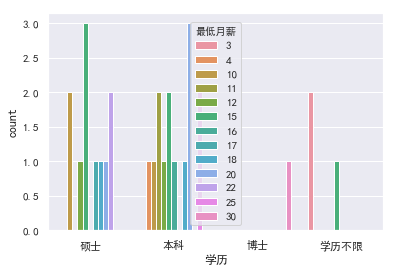

In [24]:
sns.countplot(hue="最低月薪",x="学历",data=df) 

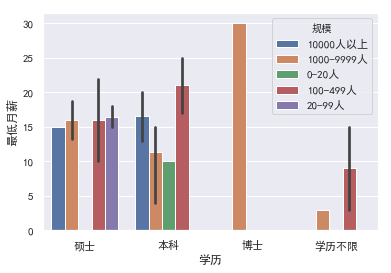

In [25]:
sns.barplot(x="学历", y="最低月薪", hue="规模",data=df)

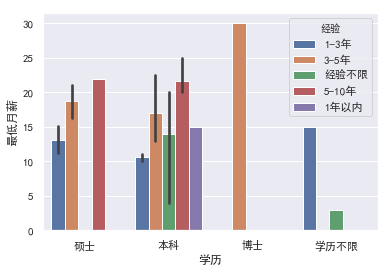

In [26]:
sns.barplot(x="学历", y="最低月薪", hue="经验",data=df)

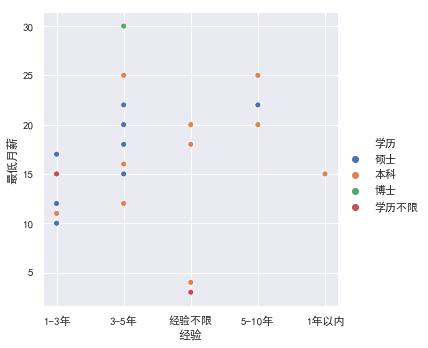

In [27]:
sns.relplot(x="经验",y="最低月薪",hue="学历",data=df);
#sns.relplot(y="学历",x="平均月薪",hue="规模",data=df);

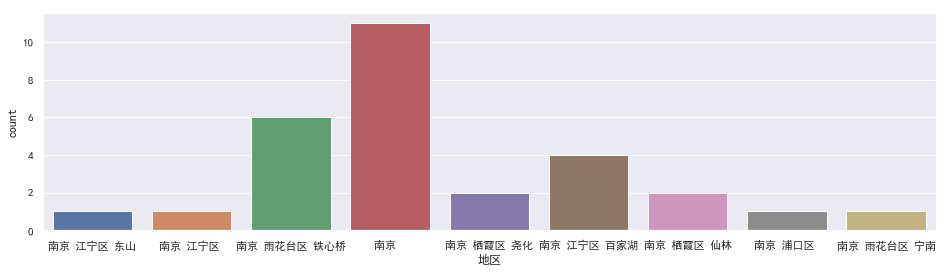

In [28]:
plt.figure(figsize=(16,4)) # this creates a figure 8 inch wide, 4 inch high
ax=sns.countplot(x="地区",data=df) 

#### 分词 topk提取 词云制作等

In [29]:
f = open("./词表/哈工大停用词表.txt",encoding='utf-8')
stopword_list = [line.strip() for line in f.readlines()]
self_defined_list = ['1','2','3','4','5','6','以上学历','关于','\n']   #自己定义的去除词
stopword_list.extend(self_defined_list)
#print(stopword_list)

def add_self_defined_words():
    jieba.add_word('机器学习')
    jieba.add_word('深度学习')


def get_words(serie):
    clean_contents=[]
    for s in serie:
        s_tmp = ''.join(s)
        #clean_s= re.sub(r'[^\u4e00-\u9fa5]', '', s_tmp)  #https://github.com/fxsjy/jieba/issues/528  这个会去除中文词之外的词
        clean_s = s_tmp
        clean_contents.append(clean_s)
      
    add_self_defined_words()
    word_list = [word for word in jieba.cut(''.join(clean_contents),cut_all=False) if word not in stopword_list]
    #print(word_list)
    
    tags=jieba.analyse.extract_tags(''.join(clean_contents), topK=20)
               
    print(tags)
    
    return word_list,tags
    
require_word_list,require_tags = get_words(df["任职要求"])
responsibility_word_list,responsibility_tags = get_words(df["岗位职责"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ThinkPad\AppData\Local\Temp\jieba.cache
Loading model cost 1.578 seconds.
Prefix dict has been built succesfully.


['NLP', '熟悉', '经验', '算法', '相关', '优先', '文本', '机器学习', '自然语言', '分词', '工作', '以上学历', '方向', 'Java', '处理', '标注', '团队', '能力', '分析', '语义']
['NLP', '文本', '负责', '自然语言', '算法', '图谱', '相关', '聚类', '分词', '知识', '处理', '识别', '经验', '机器学习', '分析', '抽取', '优先', '数据', '词性', '分类']


**任职要求数据探索**

In [30]:
# 任职要求
require_word_series = pd.Series(require_word_list)
print(require_word_series.value_counts())
print("tags***************************")
print(require_tags)

经验          35
熟悉          33
相关          28
工作          25
算法          23
NLP         22
优先          18
方向          16
文本          15
处理          15
能力          14
分析          14
以上          14
自然语言        12
年           12
机器学习        11
良好          10
团队          10
分词          10
分类           9
研究           9
语言           8
标注           8
开发           8
领域           8
技术           7
语义           7
模型           7
Java         7
至少           6
            ..
nlp          1
两餐           1
大规模          1
论文           1
最新           1
严谨           1
提升           1
版本控制         1
产学研          1
意识           1
大神           1
mysql        1
架构           1
耐心           1
细致           1
攻坚           1
Spark        1
工程师          1
双休           1
期刊论文         1
关键词          1
配备           1
计算机相关        1
机器翻译         1
导向           1
FastText     1
Hbase        1
免费           1
BAT          1
主动性          1
Length: 349, dtype: int64
tags***************************
['NLP', '熟悉', '经验', '算法', '

**岗位职责数据探索**

In [31]:
responsibility_word_series = pd.Series(responsibility_word_list)
print(responsibility_word_series.value_counts())
print("tags***************************")
print(responsibility_tags)

负责         34
相关         29
文本         26
NLP        24
处理         19
分析         19
算法         17
数据         17
经验         17
知识         16
自然语言       15
图谱         15
识别         13
工作         12
技术         12
优先         12
系统         11
开发         11
分类         11
研发         10
抽取         10
分词          9
包括          9
聚类          9
构建          9
实体          9
机器学习        8
能力          8
项目          8
挖掘          8
           ..
多个          1
开放          1
7           1
集           1
互联网         1
语法分析        1
神经网络        1
意识          1
投资          1
数据服务        1
竞品          1
句法          1
指导          1
NLPApi      1
WebAPI      1
编程          1
FinTech     1
实施          1
任职          1
c           1
重           1
习惯          1
服务器         1
辅助          1
精通          1
好           1
代码          1
协作          1
支撑          1
收集          1
Length: 340, dtype: int64
tags***************************
['NLP', '文本', '负责', '自然语言', '算法', '图谱', '相关', '聚类', '分词', '知识', '处理', '识别', '经验', '机器学习'

In [32]:
#获取特定词的出现次数
def count_specific_word(serie,word_list):
    index = [False] * len(serie)
    for w in word_list:
        tmp_list = list(serie == w)
        #print(list(tmp_list).count(True))
        
        index=list(np.logical_or(tmp_list,index))  #注意一下两个boolean list相应位置and  or的用法
        #print(index.count(True))

    return list(index).count(True)

print(count_specific_word(require_word_series,["TensorFlow"]))
print(count_specific_word(require_word_series,["经验"]))
print(count_specific_word(require_word_series,["研究生","硕士"]))
print(count_specific_word(require_word_series,["深度学习","机器学习"]))
print(count_specific_word(require_word_series,["python","Python"]))
#https://stackoverflow.com/questions/36219716/boolean-list-operation-in-python

2
35
6
16
10


In [33]:
#s='熟悉'
#t=re.sub(r'[\u4e00-\u9fa5]', '',s)
#print(s)
#print('t',t)
#if t=="":
    #print('yyyyy')

#把中文去掉
def get_englishword_list():
    l = []
    for w in require_word_list:
        w=re.sub(r'[\u4e00-\u9fa5\n\xa0]', '',w)
        if w == "":
            continue
        else:
            #print(w)
            l.append(w.lower())
    
    print(l)
    return l

enw_serie = pd.Series(get_englishword_list())
enw_serie.value_counts()


['nlp', 'tensorflow', 'linux', 'python', 'shell', 'hadoop', 'hbase', 'spark', 'rdf', '7', 'neo4j', 'titan', 'janus', '8', '9', '10', '985', '211', 'cnn', 'rnn', 'lstm', 'word2vec', 'crf', '++', 'bert', 'nlp', 'tensorflow', 'keras', 'python', 'jieba', 'stanfordnlp', 'fasttext', 'nlp', 'nlp', 'kaggle', 'nlp', 'nlp', 'standfordnlp', 'nltk', 'apacheopennlp', 'tensorflow', 'mxnet', 'kaldi', 'htk', 'hts', 'hadoop', 'c', 'c++', 'python', 'java', '211', '985', 'nlp', 'nlp', 'python', 'java', 'nlp', 'django', 'mysql', 'redis', 'mongodb', 'git', 'tensorflow', 'nlp', 'java', 'python', 'hadoop', 'spark', 'ner', 'deeplearning', 'nlp', 'bat', '10', 'macbookpro', 'nlp', 'nlp', 'python', 'java', 'c', 'c++', 'c#', '7', 'nlp', '8', 'nlp', 'nlp', 'standfordnlp', 'nltk', 'apacheopennlp', 'tensorflow', 'mxnet', 'kaldi', 'htk', 'hts', 'hadoop', 'c', 'c++', 'python', 'java', '211', '985', 'nlp', 'nlp', 'python', 'java', 'nlp', '211', '985', 'nlp', 'nlp', 'python', 'java', 'nlp', 'nlp', 'java', 'c', 'c++', 'p

nlp              23
python           10
java              8
tensorflow        5
c                 4
hadoop            4
985               4
c++               4
211               4
10                2
7                 2
nltk              2
mxnet             2
kaldi             2
8                 2
hts               2
spark             2
htk               2
standfordnlp      2
apacheopennlp     2
++                1
stanfordnlp       1
git               1
word2vec          1
rnn               1
9                 1
ner               1
hbase             1
kaggle            1
deeplearning      1
linux             1
lstm              1
titan             1
neo4j             1
fasttext          1
jieba             1
mongodb           1
shell             1
macbookpro        1
django            1
bert              1
janus             1
keras             1
bat               1
mysql             1
c#                1
crf               1
cnn               1
redis             1
rdf               1


In [34]:
from wordcloud import WordCloud, ImageColorGenerator
from scipy.misc import imread
import matplotlib.pyplot as plt
def picture(wordlist):
    font='C:\Windows\Fonts\simhei.ttf'
    wc = WordCloud(background_color="white",font_path=font,max_words=2000)
    wc.generate(" ".join(wordlist))
    
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()    

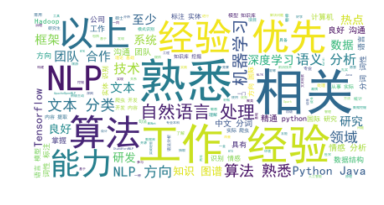

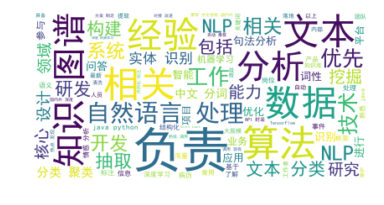

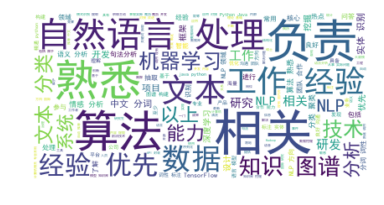

(None, None, None)

In [35]:
picture(require_word_list),picture(responsibility_word_list),picture(require_word_list+responsibility_word_list)